# 24 hr samples analysis 

Notes - https://docs.google.com/document/d/1Br8UvdCUWuVcuBxhohyOSbF-BmxKyLEfYVnFUqITHJA/edit?tab=t.0

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Reading in the data & processing

In [3]:
marti_reads = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24_hour/taxa_counts/2024_data/marti_assignments_lca_0.1_all_levels_2025-FEB-4_15-54-7.tsv", sep="\t")

def process_dataset(data):
    # Select the first 3 columns using indexing
    first_three_cols = data.iloc[:, :3]
    # Select columns where the column name contains 'summed'
    summed_cols = data.filter(like='Summed')
    summed_cols.columns = summed_cols.columns.str.split(' ').str[0]
    # Combine the first three columns with the 'summed' columns
    data_summed = pd.concat([first_three_cols, summed_cols], axis=1)
    
    return data_summed

marti = process_dataset(marti_reads)

In [44]:
collections = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24_hour/metadata/All metadata - 24 hour collections (2023 & 2024).tsv", sep="\t") 
collections['Start_Time'] = pd.to_datetime(collections['Start_Time'])
collections['End_Time'] = pd.to_datetime(collections['End_Time'])
collections['Start_Date'] = collections['Start_Time'].dt.date

### Merge on the metadata to get contig stats and calculate HPM

- for now marti data is jut 2024
- but could open it all up in the front end to compare both years

In [21]:
#Melt the data to long
marti_long = marti.melt(
    id_vars = ['Name', 'NCBI ID', 'NCBI Rank'],           # the columns we want to keep
    var_name = 'Sample',    # the name of the new column with old column names (to contain the cols we are combining)
    value_name = 'read count' # the name of the new column with old column values
)

# Merge the metadata with the long data
marti_meta = marti_long.merge(collections, left_on='Sample', right_on='Sample_ID')
marti_meta.drop(columns=['Sample_ID'], inplace=True)

## Looking at collection metadata

<Axes: xlabel='Duration_Hrs', ylabel='Counts'>

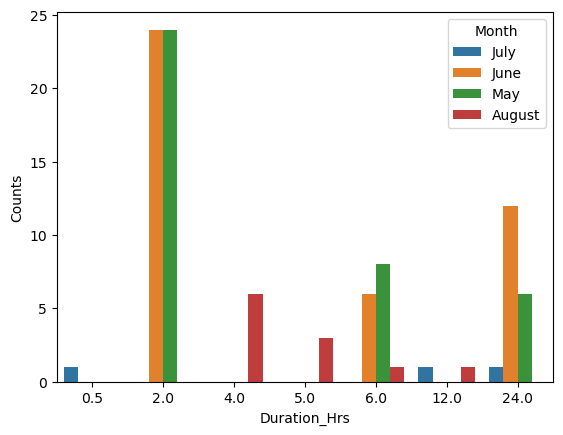

In [12]:
month_duration = collections.groupby(['Duration_Hrs', 'Month']).size().reset_index(name='Counts')
month_duration = month_duration[month_duration['Duration_Hrs'] > 0]

day_duration = collections.groupby(['Duration_Hrs', 'Start_Date']).size().reset_index(name='Counts')
day_duration = day_duration.sort_values(by='Start_Date')
# Convert Start_Date to string for hue
day_duration['Start_Date'] = day_duration['Start_Date'].astype(str)

# bar chart showing how many samples were taken for each duration
# additional 24 hr samples were collected on other days
# sns.barplot(data=day_duration,
#             x='Duration_Hrs',
#             y='Counts',
#             hue='Start_Date')

#Just month - can see additional June 24 hr samples
sns.barplot(data=month_duration,
            x='Duration_Hrs',
            y='Counts',
            hue='Month')

### DNA yield and collection duration

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_35820/1202238514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_collections['Duration_Hrs'] = filtered_collections['Duration_Hrs'].dropna().astype(int)
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_35820/1202238514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_collections['LPM'] = filtered_collections['LPM'].astype(str).str.split('.').str[0]


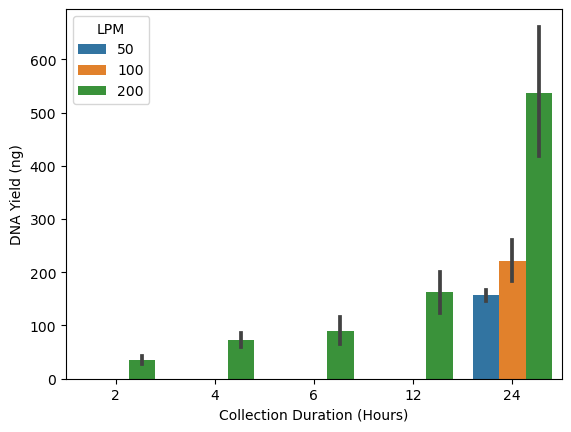

In [52]:
#filtering out the 0.5 sample as it was collected in the lab so not comparable to the field 
filtered_collections = collections[(collections['Duration_Hrs'] > 0.5)]
#Dropping na and making the numbers look nicer
filtered_collections['Duration_Hrs'] = filtered_collections['Duration_Hrs'].dropna().astype(int)

# Convert LPM to string to avoid AttributeError
filtered_collections['LPM'] = filtered_collections['LPM'].astype(str).str.split('.').str[0]

# Define the specific order for LPM values
lpm_order = ['50', '100', '200']

# Set the order for the hue in the barplot
sns.barplot(data=filtered_collections,
            x='Duration_Hrs',
            y='DNA_yield_ng',
            hue='LPM',
            hue_order=lpm_order)

# Set x and y labels
plt.xlabel('Collection Duration (Hours)')
plt.ylabel('DNA Yield (ng)')

# plt.savefig('../Graphs/DNA_yield_vs_duration_lpm.png')